Predicción de Aportes Mensuales del SIN
====

Carga de datos
---

In [1]:
import pandas as pd
import requests

owner = "jdvelasq"
repo = "datalabs"
folder = "datasets/aportes_diarios/csv/"

api_url = f"https://api.github.com/repos/{owner}/{repo}/contents/{folder}"
response = requests.get(api_url)

base_url = f"https://raw.githubusercontent.com/{owner}/{repo}/master/{folder}"

dfs = []
for file in response.json():
    file_url = base_url + file["name"]
    df = pd.read_csv(file_url, sep=";", decimal=",", thousands=".")
    dfs.append(df)

df_concat = pd.concat(dfs, ignore_index=True)
print(df_concat.head())

        Fecha Region Hidrologica                 Nombre Río   
0  2000-01-01          ANTIOQUIA             A. SAN LORENZO  \
1  2000-01-01          ANTIOQUIA                 CONCEPCION   
2  2000-01-01          ANTIOQUIA  DESV. EEPPM (NEC,PAJ,DOL)   
3  2000-01-01          ANTIOQUIA                     GRANDE   
4  2000-01-01          ANTIOQUIA                  GUADALUPE   

   Aportes Caudal m3/s  Aportes Energía kWh Aportes %  
0                18.50            3924500.0    65,08%  
1                 5.37            1103300.0   110,33%  
2                 9.98            2050500.0   130,61%  
3                28.03            5192100.0   120,19%  
4                15.82            3250400.0   112,86%  


Homogenización de nombres de columnas
---

In [2]:
df_concat = df_concat.rename(
    columns={
        "Fecha": "fecha",
        "Region Hidrologica": "region",
        "Nombre Río": "rio",
        "Aportes Caudal m3/s": "caudal",
        "Aportes Energía kWh": "energia",
        "Aportes %": "porcentaje",
    }
)

df_concat

,fecha,region,rio,caudal,energia,porcentaje
0,2000-01-01,ANTIOQUIA,A. SAN LORENZO,18.50,3924500.0,"65,08%"
1,2000-01-01,ANTIOQUIA,CONCEPCION,5.37,1103300.0,"110,33%"
2,2000-01-01,ANTIOQUIA,"DESV. EEPPM (NEC,PAJ,DOL)",9.98,2050500.0,"130,61%"
3,2000-01-01,ANTIOQUIA,GRANDE,28.03,5192100.0,"120,19%"
4,2000-01-01,ANTIOQUIA,GUADALUPE,15.82,3250400.0,"112,86%"
...,...,...,...,...,...,...
201921,2021-12-31,VALLE,CALIMA,16.66,724600.0,"103,51%"
201922,2021-12-31,VALLE,CAUCA SALVAJINA,257.67,5224900.0,"122,08%"
201923,2021-12-31,VALLE,DIGUA,48.29,699800.0,"132,04%"
201924,2021-12-31,VALLE,FLORIDA II,9.85,197000.0,"109,44%"


Preparación columna caudal
----

In [3]:
df_concat = df_concat[["fecha", "rio", "caudal"]]
df_concat

,fecha,rio,caudal
0,2000-01-01,A. SAN LORENZO,18.50
1,2000-01-01,CONCEPCION,5.37
2,2000-01-01,"DESV. EEPPM (NEC,PAJ,DOL)",9.98
3,2000-01-01,GRANDE,28.03
4,2000-01-01,GUADALUPE,15.82
...,...,...,...
201921,2021-12-31,CALIMA,16.66
201922,2021-12-31,CAUCA SALVAJINA,257.67
201923,2021-12-31,DIGUA,48.29
201924,2021-12-31,FLORIDA II,9.85


Eliminación de NAs
----

In [4]:
df_concat = df_concat.dropna()

Preprocesamiento 
---

In [5]:
#
# Generación de la columna año - mes
#
df_concat = df_concat.assign(ano=df_concat["fecha"].str[:4])
df_concat = df_concat.assign(mes=df_concat["fecha"].str[5:7])
df_concat

,fecha,rio,caudal,ano,mes
0,2000-01-01,A. SAN LORENZO,18.50,2000,01
1,2000-01-01,CONCEPCION,5.37,2000,01
2,2000-01-01,"DESV. EEPPM (NEC,PAJ,DOL)",9.98,2000,01
3,2000-01-01,GRANDE,28.03,2000,01
4,2000-01-01,GUADALUPE,15.82,2000,01
...,...,...,...,...,...
201920,2021-12-31,ALTOANCHICAYA,70.08,2021,12
201921,2021-12-31,CALIMA,16.66,2021,12
201922,2021-12-31,CAUCA SALVAJINA,257.67,2021,12
201923,2021-12-31,DIGUA,48.29,2021,12


In [6]:
#
# Cálculo del caudal promedio mensual
#
caudal_prom_mensual = df_concat[["ano", "mes", "rio", "caudal"]]
caudal_prom_mensual = caudal_prom_mensual.groupby(
    ["rio", "ano", "mes"], as_index=False
).agg("mean")
caudal_prom_mensual.head(10)

,rio,ano,mes,caudal
0,A. SAN LORENZO,2000,01,18.823226
1,A. SAN LORENZO,2000,02,20.944138
2,A. SAN LORENZO,2000,03,20.465161
3,A. SAN LORENZO,2000,04,29.197000
4,A. SAN LORENZO,2000,05,58.759032
5,A. SAN LORENZO,2000,06,69.072000
6,A. SAN LORENZO,2000,07,64.742903
7,A. SAN LORENZO,2000,08,63.440968
8,A. SAN LORENZO,2000,09,78.647000
9,A. SAN LORENZO,2000,10,62.897419


In [7]:
#
# Media multianual
#
caudal_prom_mensual["media"] = caudal_prom_mensual.groupby(
    ["rio", "mes"], as_index=False
)["caudal"].transform("mean")

caudal_prom_mensual["desvest"] = caudal_prom_mensual.groupby(
    ["rio", "mes"], as_index=False
)["caudal"].transform("std")

caudal_prom_mensual

,rio,ano,mes,caudal,media,desvest
0,A. SAN LORENZO,2000,01,18.823226,22.849633,7.683702
1,A. SAN LORENZO,2000,02,20.944138,21.802286,8.342737
2,A. SAN LORENZO,2000,03,20.465161,27.192796,10.879506
3,A. SAN LORENZO,2000,04,29.197000,37.643984,12.428113
4,A. SAN LORENZO,2000,05,58.759032,53.741075,17.915003
...,...,...,...,...,...,...
6378,TENCHE,2021,08,5.727419,4.903011,1.434027
6379,TENCHE,2021,09,6.037000,5.052683,1.722873
6380,TENCHE,2021,10,6.575806,5.197343,1.378708
6381,TENCHE,2021,11,4.068000,4.792651,1.426030


In [8]:
#
# Caudal normalizado
#
caudal_prom_mensual["z"] = (
    caudal_prom_mensual["caudal"] - caudal_prom_mensual["media"]
) / caudal_prom_mensual["desvest"]

caudal_prom_mensual

,rio,ano,mes,caudal,media,desvest,z
0,A. SAN LORENZO,2000,01,18.823226,22.849633,7.683702,-0.524019
1,A. SAN LORENZO,2000,02,20.944138,21.802286,8.342737,-0.102862
2,A. SAN LORENZO,2000,03,20.465161,27.192796,10.879506,-0.618377
3,A. SAN LORENZO,2000,04,29.197000,37.643984,12.428113,-0.679667
4,A. SAN LORENZO,2000,05,58.759032,53.741075,17.915003,0.280098
...,...,...,...,...,...,...,...
6378,TENCHE,2021,08,5.727419,4.903011,1.434027,0.574891
6379,TENCHE,2021,09,6.037000,5.052683,1.722873,0.571323
6380,TENCHE,2021,10,6.575806,5.197343,1.378708,0.999823
6381,TENCHE,2021,11,4.068000,4.792651,1.426030,-0.508160


In [9]:
caudal_prom_mensual.rio.drop_duplicates()

0                  A. SAN LORENZO
254                 ALTOANCHICAYA
497                         AMOYA
591                          BATA
845                    BETANIA CP
909                        BLANCO
933                   BOGOTA N.R.
1187                       CALIMA
1441                CARLOS LLERAS
1477              CAUCA SALVAJINA
1731                        CHUZA
1985                   CONCEPCION
2239                      CUCUANA
2275    DESV. EEPPM (NEC,PAJ,DOL)
2529                DESV. GUARINO
2553                  DESV. MANSO
2646             DESV. SAN MARCOS
2682                        DIGUA
2925                    EL QUIMBO
2989                   FLORIDA II
3231                       GRANDE
3485                    GUADALUPE
3739                      GUATAPE
3993                       GUAVIO
4247            MAGDALENA BETANIA
4437                       MIEL I
4656                         NARE
4910                     PORCE II
5105                    PORCE III
5227          

In [10]:
#
# Se selecciona arbitrariamente Miel I
#
miel = caudal_prom_mensual.loc[caudal_prom_mensual.rio == 'MIEL I', :]
miel = miel.sort_values(['ano', 'mes'], ascending=True)
miel = miel.reset_index(drop=True)
miel

,rio,ano,mes,caudal,media,desvest,z
0,MIEL I,2002,12,86.300000,115.145914,49.469120,-0.583109
1,MIEL I,2003,01,48.707419,93.429830,46.537674,-0.960994
2,MIEL I,2003,02,48.258571,84.957152,32.442290,-1.131196
3,MIEL I,2003,03,64.661290,94.654480,28.077482,-1.068229
4,MIEL I,2003,04,76.045000,86.222852,29.343489,-0.346852
...,...,...,...,...,...,...,...
214,MIEL I,2021,08,70.004516,40.166022,21.886092,1.363354
215,MIEL I,2021,09,58.833000,56.559370,26.137309,0.086988
216,MIEL I,2021,10,57.112258,80.493853,31.914298,-0.732637
217,MIEL I,2021,11,91.285667,117.866889,44.239004,-0.600855


Pronóstico del caudal
----

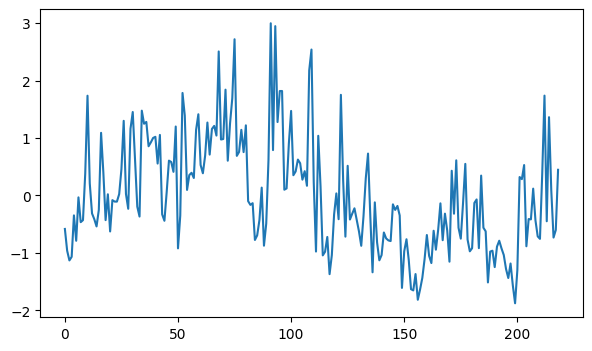

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(miel.z)
plt.show()

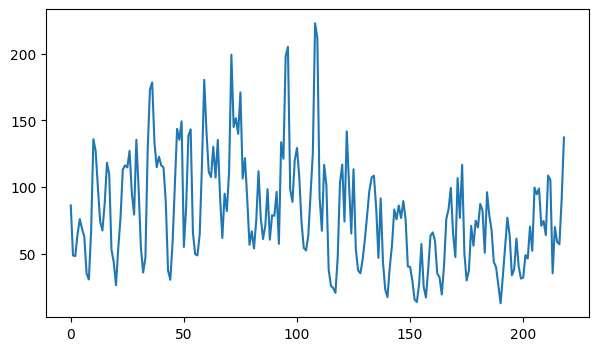

In [12]:
plt.figure(figsize=(7, 4))
plt.plot(miel.caudal)
plt.show()

In [13]:
data = miel[['z']].copy()
for lag in range(1, 7):
    z = miel[['z']].copy()
    z = z.shift(periods=lag, fill_value=0)
    z.columns = [f'lag{lag:d}']
    data = pd.concat([data, z], axis=1)

data = data.dropna()
data.head(20)

,z,lag1,lag2,lag3,lag4,lag5,lag6
0,-0.583109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.960994,-0.583109,0.000000,0.000000,0.000000,0.000000,0.000000
2,-1.131196,-0.960994,-0.583109,0.000000,0.000000,0.000000,0.000000
3,-1.068229,-1.131196,-0.960994,-0.583109,0.000000,0.000000,0.000000
4,-0.346852,-1.068229,-1.131196,-0.960994,-0.583109,0.000000,0.000000
5,-0.789074,-0.346852,-1.068229,-1.131196,-0.960994,-0.583109,0.000000
6,-0.033272,-0.789074,-0.346852,-1.068229,-1.131196,-0.960994,-0.583109
7,-0.464947,-0.033272,-0.789074,-0.346852,-1.068229,-1.131196,-0.960994
8,-0.430125,-0.464947,-0.033272,-0.789074,-0.346852,-1.068229,-1.131196
9,0.385182,-0.430125,-0.464947,-0.033272,-0.789074,-0.346852,-1.068229


In [14]:
#
# Tamaño del dataframe
#
data.shape

(219, 7)

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression

gridSearchCV = GridSearchCV(
    #
    # Tuberia:
    estimator=make_pipeline(
        SelectKBest(score_func=f_regression),
        LinearRegression(),
    ),
    #
    # Hiperparámetros
    param_grid={
        'selectkbest__k': range(1, 7),
    },
    #
    # Esquema de validación cruzada
    cv=LeaveOneOut(),
    #
    # Métrica:
    scoring="neg_mean_squared_error",
)

gridSearchCV.fit(data.iloc[:, 1:], data.iloc[:, 0])
gridSearchCV.best_params_

{'selectkbest__k': 4}

Predicción un mes adelante
---

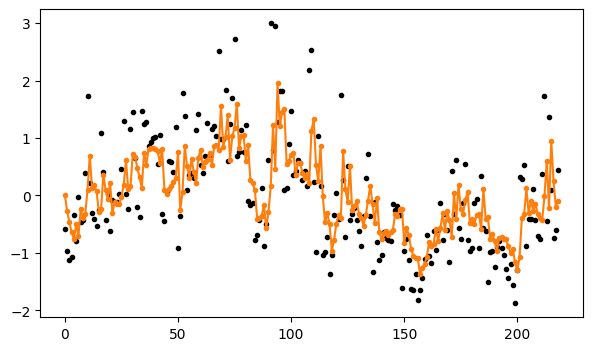

In [16]:
#
# Datos normalizados:
#
pronostico = gridSearchCV.predict(data.iloc[:, 1:])

plt.figure(figsize=(7, 4))
plt.plot(data.iloc[:, 0], '.k')
plt.plot(pronostico, '.-', color='tab:orange')
plt.show()

Pronóstico siguientes 12 meses
---

In [17]:
#
# Ultimos 6 valores:
#
z_pred = miel['z'].to_list()
z_pred[-6:]

[-0.4492764339010605,
 1.36335414278238,
 0.08698789899864781,
 -0.7326369913693848,
 -0.6008549012629729,
 0.4470497467418994]

In [18]:
#
# Ultimos 6 valores convertidos a una lista de listas:
#
[z_pred[-6:]]

[[-0.4492764339010605,
  1.36335414278238,
  0.08698789899864781,
  -0.7326369913693848,
  -0.6008549012629729,
  0.4470497467418994]]

In [19]:
#
# Pronostico del siguiente valor:
#
z_point = pd.DataFrame(
    {
    'lag1': [z_pred[-1]],
    'lag2': [z_pred[-2]],
    'lag3': [z_pred[-3]],
    'lag4': [z_pred[-4]],
    'lag5': [z_pred[-5]],
    'lag6': [z_pred[-6]],
    }
)
z_point

,lag1,lag2,lag3,lag4,lag5,lag6
0,0.44705,-0.600855,-0.732637,0.086988,1.363354,-0.449276


In [20]:
gridSearchCV.predict(z_point)

array([0.09399993])

In [21]:
gridSearchCV.predict(z_point)[0]

0.09399992667978989

In [22]:
#
# Pronostico hacia adelante
#
z_pred = miel['z'].to_list()

for k in range(1, 12):
    
    z = pd.DataFrame(
        {
        'lag1': [z_pred[-1]],
        'lag2': [z_pred[-2]],
        'lag3': [z_pred[-3]],
        'lag4': [z_pred[-4]],
        'lag5': [z_pred[-5]],
        'lag6': [z_pred[-6]],
        }
    )
    
    y = gridSearchCV.predict(z)[0]
    z_pred += [y]

z_pred[-20:]

[-0.7558696311664597,
 0.3785568687510893,
 1.7387279863689598,
 -0.4492764339010605,
 1.36335414278238,
 0.08698789899864781,
 -0.7326369913693848,
 -0.6008549012629729,
 0.4470497467418994,
 0.09399992667978989,
 -0.14218600955455485,
 -0.08011930759957069,
 0.03650019975340008,
 0.006226590328926463,
 -0.02892303367320035,
 -0.019275249649277962,
 -0.0038196105322661645,
 -0.006064686142144557,
 -0.010215492904360501,
 -0.008455976860362509]

Transformación de los pronósticos a las unidades originales
---

In [23]:
pronostico = pd.DataFrame(
    {
        'rio': ['MIEL I'] * 12,
        'ano': [2022] * 12,
        'mes': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11' , '12'],
        'caudal': [0] * 12, 
        'media': miel.iloc[-12:, 4].to_list(),  
        'desvest': miel.iloc[-12:, 5].to_list(),  
        'z': z_pred[-12:],
    }
)

pronostico

,rio,ano,mes,caudal,media,desvest,z
0,MIEL I,2022,01,0,93.429830,46.537674,0.447050
1,MIEL I,2022,02,0,84.957152,32.442290,0.094000
2,MIEL I,2022,03,0,94.654480,28.077482,-0.142186
3,MIEL I,2022,04,0,86.222852,29.343489,-0.080119
4,MIEL I,2022,05,0,95.709606,34.279779,0.036500
5,MIEL I,2022,06,0,63.538000,24.144471,0.006227
6,MIEL I,2022,07,0,43.356001,17.723554,-0.028923
7,MIEL I,2022,08,0,40.166022,21.886092,-0.019275
8,MIEL I,2022,09,0,56.559370,26.137309,-0.003820
9,MIEL I,2022,10,0,80.493853,31.914298,-0.006065


In [24]:
pronostico = pronostico.assign(caudal=pronostico.z * pronostico.desvest + pronostico.media)
pronostico

,rio,ano,mes,caudal,media,desvest,z
0,MIEL I,2022,01,114.234486,93.429830,46.537674,0.447050
1,MIEL I,2022,02,88.006725,84.957152,32.442290,0.094000
2,MIEL I,2022,03,90.662255,94.654480,28.077482,-0.142186
3,MIEL I,2022,04,83.871872,86.222852,29.343489,-0.080119
4,MIEL I,2022,05,96.960825,95.709606,34.279779,0.036500
5,MIEL I,2022,06,63.688338,63.538000,24.144471,0.006227
6,MIEL I,2022,07,42.843382,43.356001,17.723554,-0.028923
7,MIEL I,2022,08,39.744162,40.166022,21.886092,-0.019275
8,MIEL I,2022,09,56.459536,56.559370,26.137309,-0.003820
9,MIEL I,2022,10,80.300303,80.493853,31.914298,-0.006065


In [25]:
pronostico = pd.concat([miel, pronostico], axis=0, ignore_index=True)
pronostico.tail(20)

,rio,ano,mes,caudal,media,desvest,z
211,MIEL I,2021,05,108.686452,95.709606,34.279779,0.378557
212,MIEL I,2021,06,105.518667,63.538000,24.144471,1.738728
213,MIEL I,2021,07,35.393226,43.356001,17.723554,-0.449276
214,MIEL I,2021,08,70.004516,40.166022,21.886092,1.363354
215,MIEL I,2021,09,58.833000,56.559370,26.137309,0.086988
216,MIEL I,2021,10,57.112258,80.493853,31.914298,-0.732637
217,MIEL I,2021,11,91.285667,117.866889,44.239004,-0.600855
218,MIEL I,2021,12,137.261071,115.145914,49.469120,0.447050
219,MIEL I,2022,01,114.234486,93.429830,46.537674,0.447050
220,MIEL I,2022,02,88.006725,84.957152,32.442290,0.094000


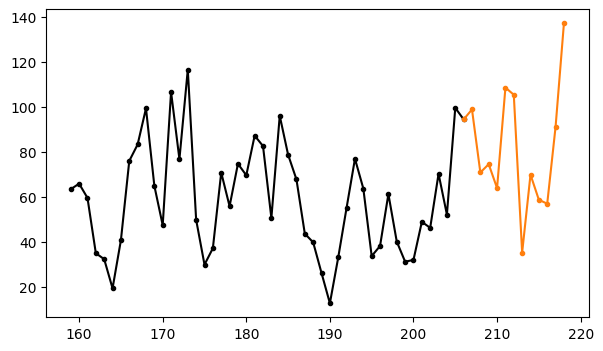

In [26]:
plt.figure(figsize=(7, 4))
plt.plot(miel.caudal[-60:-12], '.-k')
plt.plot(miel.caudal[-13:], '.-', color='tab:orange')
plt.show()